## Data simulation

Reference: https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full

1. Define the Observation Period and Initial Fill:
- Every individual starts on the same day with an initial fill that covers 30 days.
- This ensures all individuals “initiate” treatment simultaneously.

2. Simulate Subsequent Refills:
- After the initial fill, each subsequent refill’s duration is randomly chosen from a discrete set (typically 30, 60, or 90 days).
- Refills continue until the observation period ends.
- For each refill, you update the refill date by adding the chosen duration (plus any group-specific delay).

3. Introduce Group-Specific Patterns:
- Individuals are assigned to one of six groups with distinct refill behaviors. For example:

    - Group 1 (“High adherence”): Refills occur on time, leading to near-perfect adherence.
    - Group 2 (“Erratic adherence”): Refills are more variable (with additional random delays).
    - Group 3 (“Gradual decline”): The delay between refills increases over time.
    - Group 4 (“Intermittent adherence”): Refills alternate between on‐time and delayed refills.
    - Group 5 (“Partial drop-off”): Initially good adherence with a later drop-off.
    - Group 6 (“Non-persistence”): Only one or two refills occur before treatment stops. – The simulation can “tune” these patterns by, for example, adding extra delay (or even ceasing refills) according to the group.
4. Generate Multiple Individuals:
- Repeat the process for a specified number of individuals (e.g., 1000) while randomly assigning each individual to a group (often with predetermined proportions—for instance, groups 1 and 6 might each be 10% of the sample).

5. Create the Final Dataset:
- The resulting dataset should record for each individual the dates of each refill, the duration supplied, and (optionally) the group membership.
- This simulated refill history can then be used to calculate longitudinal adherence metrics (such as LCMA1 or LCMA2) with sliding windows.

### Import Libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Define Function/s

In [29]:
def simulate_refill_history(n_individuals=1000, obs_period=720):
    # Define group probabilities (e.g., groups 1 and 6 are 10% each)
    group_probs = [0.1, 0.2, 0.2, 0.2, 0.2, 0.1]
    groups = np.random.choice(np.arange(1,7), size=n_individuals, p=group_probs)

    data_list = []
    for i in range(n_individuals):
        group = groups[i]
        refill_dates = [0]  # start at day 0
        current_day = 0

        while current_day < obs_period:
            refill_duration = np.random.choice([30, 60, 90])

            # Group-specific behavior
            if group == 3:
                extra_delay = np.random.randint(0, 11) * len(refill_dates)
            elif group == 2:
                extra_delay = np.random.randint(0, 21)
            elif group == 6 and len(refill_dates) > 1:
                # Non-persistence: stop after the first refill
                break
            else:
                extra_delay = 0

            current_day += refill_duration + extra_delay
            if current_day <= obs_period:
                refill_dates.append(current_day)
            else:
                break

        # Create a DataFrame for this individual
        individual_df = pd.DataFrame({
            'individual': i+1,
            'group': group,
            'refill_date': refill_dates
        })
        individual_df['refill_duration'] = individual_df['refill_date'].diff()
        data_list.append(individual_df)

    simulated_data = pd.concat(data_list, ignore_index=True)
    return simulated_data

#### Simulated Data Features:
- individual: patient ID
- group: simulated adherence group (not used in clustering)
- refill_date: the refill day (numeric, representing days from treatment initiation)
- refill_duration: the difference between consecutive refill dates

### Generate simulated data

In [97]:
export_df = simulate_refill_history()

export_df.tail()

,individual,group,refill_date,refill_duration
10662,1000,4,540,30.0
10663,1000,4,630,90.0
10664,1000,4,660,30.0
10665,1000,4,690,30.0
10666,1000,4,720,30.0


### Export simulated data

In [99]:
export_df.to_csv('../data/simulated_data.csv', index=False)

In [93]:
def See(data):
    """
    Sessa Empirical Estimator using K-means clustering.

    This function expects a DataFrame (e.g. from simulate_refill_history) with at least:
      - 'individual': patient ID
      - 'refill_date': the refill day (numeric, e.g. 0, 30, 90, ...)
      - (optionally) 'group': the simulated adherence group

    Then it:
      1. Sorts the data by patient and refill date.
      2. Computes the lag refill date (prev_refill_date) for each patient.
      3. Keeps only patients with at least one refill (i.e. with a non-null prev_refill_date)
         and randomly samples one event per patient.
      4. Computes the event interval (difference in days).
      5. Computes the empirical CDF (ECDF) of these intervals and retains the lower 80%.
      6. Estimates a density on the log-transformed intervals and performs silhouette
         analysis to determine the optimal number of clusters.
      7. Runs k-means clustering on the ECDF x-values and, for each cluster, computes
         summary thresholds (minimum, maximum, median) after back-transforming.
      8. Cross-joins these thresholds with the patient-level data and assigns a cluster
         if the event interval falls within a cluster’s [Minimum, Maximum] range.
      9. Uses the most frequent cluster’s median as a fallback, and adds a “test” column
         (difference between event interval and median).

    Returns a DataFrame with additional columns: 'event_interval', 'Median', 'Cluster', and 'test'.
    """
    # Rename columns for consistency.
    df = data.copy()

    # Sort by patient and refill date; compute the previous refill date for each patient.
    df_sorted = df.sort_values(by=['individual', 'refill_date']).copy()
    df_sorted['prev_refill_date'] = df_sorted.groupby('individual')['refill_date'].shift(1)

    # Keep only rows with a previous event.
    df_sample = df_sorted.dropna(subset=['prev_refill_date']).copy()

    # For each patient, randomly sample one refill event.
    df_sample = (df_sample.groupby('individual', group_keys=False)
                 .apply(lambda x: x.sample(n=1, random_state=1234))
                 .reset_index(drop=True))

    # Compute the event interval. For simulated data, 'refill_date' is numeric.
    df_sample['event_interval'] = df_sample['refill_date'] - df_sample['prev_refill_date']

    # --- ECDF Calculation ---
    intervals = np.sort(df_sample['event_interval'].values)
    n = len(intervals)
    y_ecdf = np.arange(1, n + 1) / n
    df_ecdf = pd.DataFrame({'x': intervals, 'y': y_ecdf})

    # Retain the lower 80% of the ECDF.
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8].copy()
    ni = df_ecdf_80['x'].max()

    # (Optional) Plot the ECDFs.
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(df_ecdf_80['x'], df_ecdf_80['y'])
    plt.title("80% ECDF")
    plt.xlabel("Event Interval")
    plt.ylabel("ECDF")
    plt.subplot(1, 2, 2)
    plt.scatter(df_ecdf['x'], df_ecdf['y'])
    plt.title("100% ECDF")
    plt.xlabel("Event Interval")
    plt.ylabel("ECDF")
    plt.tight_layout()
    plt.show()

    # (Optional) Plot patient frequency.
    freq = df_sample['individual'].value_counts()
    plt.figure(figsize=(6, 4))
    freq.plot(kind='bar', title="Frequency of individual")
    plt.xlabel("individual")
    plt.ylabel("Count")
    plt.show()

    # Select rows with event_interval <= ni.
    df_for_density = df_sample[df_sample['event_interval'] <= ni].copy()

    # Density estimation on the log-transformed event intervals.
    log_intervals = np.log(df_for_density['event_interval'])
    grid = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    kde = gaussian_kde(log_intervals)
    density_values = kde(grid)
    plt.figure(figsize=(6, 4))
    plt.plot(grid, density_values)
    plt.title("Density of log(Event Interval)")
    plt.xlabel("log(Event Interval)")
    plt.ylabel("Density")
    plt.show()

    # Create a DataFrame from the density estimation and scale it.
    density_df = pd.DataFrame({'x': grid, 'y': density_values})
    scaler = StandardScaler()
    density_scaled = scaler.fit_transform(density_df)

    # Silhouette analysis to choose the optimal number of clusters.
    best_k = 2
    best_score = -1
    max_k = min(10, len(density_scaled))
    for k in range(2, max_k + 1):
        km_temp = KMeans(n_clusters=k, random_state=1234, n_init=10)
        labels_temp = km_temp.fit_predict(density_scaled)
        score = silhouette_score(density_scaled, labels_temp)
        if score > best_score:
            best_score = score
            best_k = k
    optimal_k = best_k
    print("Optimal number of clusters:", optimal_k)

    # K-means clustering on the full ECDF x-values.
    x_for_cluster = df_ecdf['x'].values.reshape(-1, 1)
    km = KMeans(n_clusters=optimal_k, random_state=1234)
    cluster_labels = km.fit_predict(x_for_cluster)
    df_ecdf['cluster'] = cluster_labels
    df_ecdf['log_x'] = np.log(df_ecdf['x'])

    # For each cluster, compute the minimum, maximum, and median of log_x; then back-transform.
    summary = (df_ecdf.groupby('cluster')['log_x']
               .agg(['min', 'max', 'median'])
               .reset_index())
    summary['min'] = summary['min'].replace(-np.inf, 0)
    summary['Minimum'] = np.exp(summary['min'])
    summary['Maximum'] = np.exp(summary['max'])
    summary['Median'] = np.exp(summary['median'])
    summary = summary[summary['Median'] > 0]
    summary = summary[['cluster', 'Minimum', 'Maximum', 'Median']].rename(columns={'cluster': 'Cluster_sum'})

    # Cross join: assign every row in df_sample the summary thresholds.
    df_sample['key'] = 1
    summary['key'] = 1
    cross = pd.merge(df_sample, summary, on='key').drop('key', axis=1)

    # Assign a Final_cluster value if the event_interval falls within the thresholds.
    cross['Final_cluster'] = np.where(
        (cross['event_interval'] >= cross['Minimum']) & (cross['event_interval'] <= cross['Maximum']),
        cross['Cluster_sum'], np.nan
    )
    results = cross.dropna(subset=['Final_cluster']).copy()
    results = results[['individual', 'Median', 'Cluster_sum']].rename(columns={'Cluster_sum': 'Cluster'})

    # Use the most frequent cluster's median as a fallback.
    if not results.empty:
        top_cluster = results['Cluster'].value_counts().idxmax()
        fallback_median = results.loc[results['Cluster'] == top_cluster, 'Median'].iloc[0]
    else:
        fallback_median = np.nan

    # Merge the cluster results back into the sampled data.
    df_sample = pd.merge(df_sample, results, on='individual', how='left', suffixes=('', '_res'))
# The merge will bring in the "Median" column from results (no suffix needed)
    df_sample['Median'] = df_sample['Median'].fillna(fallback_median)
    df_sample['Cluster'] = df_sample['Cluster'].fillna(0)
    df_sample['test'] = np.round(df_sample['event_interval'] - df_sample['Median'], 1)

    # Select and return relevant columns.
    df_final = df_sample[['individual', 'refill_date', 'prev_refill_date', 'event_interval', 'Median', 'Cluster', 'test']].copy()
    return df_final

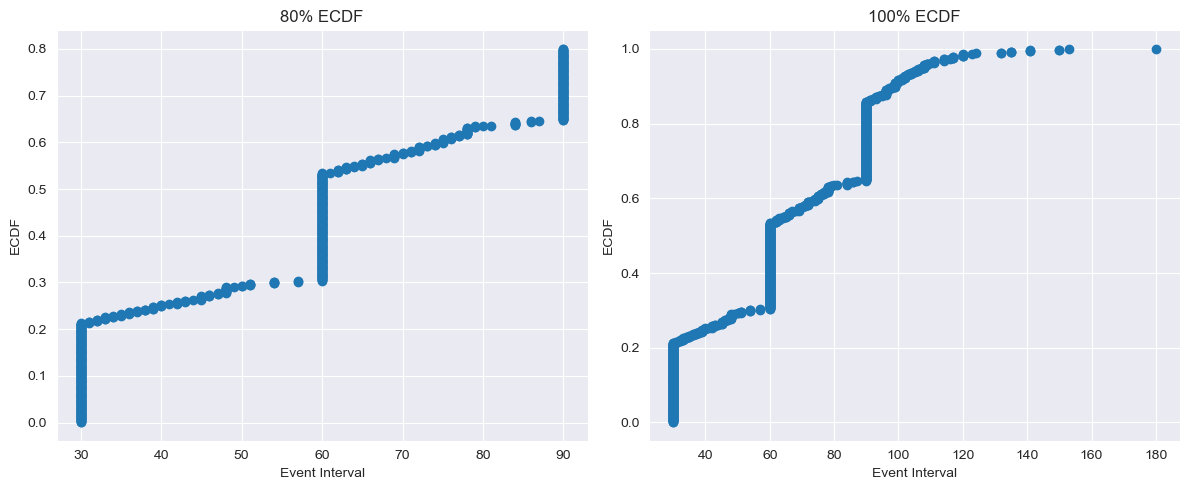

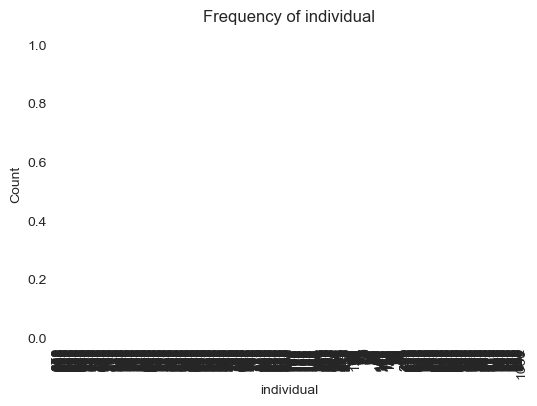

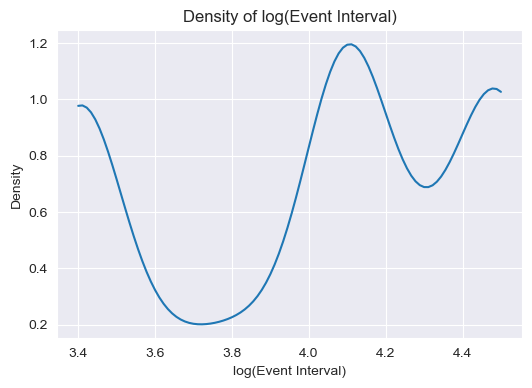

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Optimal number of clusters: 3


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,individual,refill_date,prev_refill_date,event_interval,Median,Cluster,test
995,996,60,0.0,60.0,60.0,2.0,0.0
996,997,480,420.0,60.0,60.0,2.0,0.0
997,998,540,480.0,60.0,60.0,2.0,0.0
998,999,571,539.0,32.0,30.0,0.0,2.0
999,1000,30,0.0,30.0,90.0,0.0,-60.0


In [94]:
see_df = See(sample_df)

see_df.tail()

In [95]:
def see_assumption(data):
    """
    Given a DataFrame (df_final) from the Sessa Empirical Estimator,
    this function creates a boxplot of the refill event intervals (in days)
    grouped by the assigned Cluster. It also draws a horizontal dashed red line
    at the overall median event interval.

    Parameters:
      data (DataFrame): The output from the Sessa estimator containing at least
                        'individual', 'event_interval', and 'Cluster'.

    Returns:
      Matplotlib Figure object.
    """
    # Create a copy so as not to modify the original data.
    df = data.copy()

    # Ensure the Cluster column is treated as categorical.
    df['Cluster'] = df['Cluster'].astype('category')

    # Compute the overall median event interval.
    overall_median = df['event_interval'].median()

    # Create the boxplot.
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(x='Cluster', y='event_interval', data=df)
    ax.set_title("Boxplot of Refill Event Interval by Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Event Interval (days)")

    # Add a horizontal dashed line at the overall median.
    plt.axhline(y=overall_median, color='red', linestyle='dashed',
                label=f'Overall median = {overall_median:.1f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return plt.gcf()

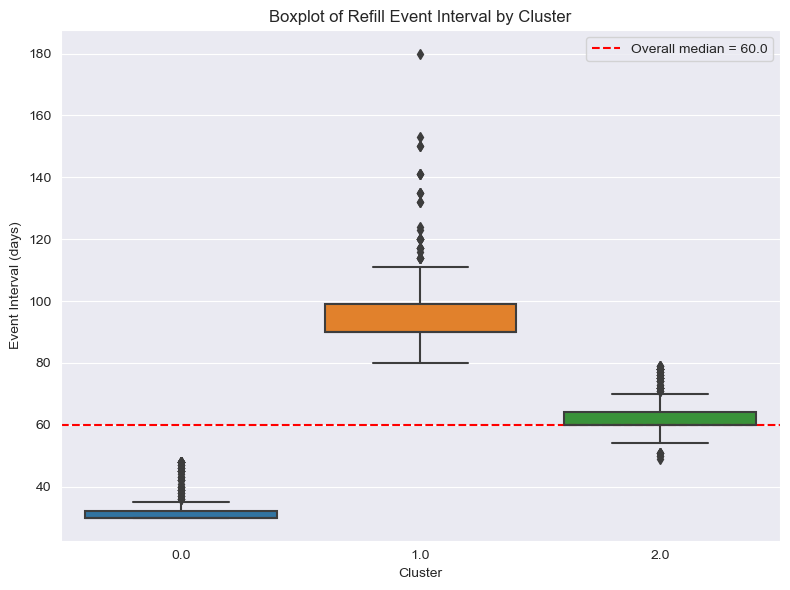

<Figure size 640x480 with 0 Axes>

In [96]:
fig = see_assumption(see_df)